In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/delicious_csv

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [ ]:
item_embeddings = pd.read_csv("norm_matrix_ejml_full_delicious.csv", header=None)
item_embeddings.sort_values(0, inplace=True)
book = pd.read_csv("bookmarks.csv")
book_tags = pd.read_csv("bookmark_tags.csv")
tags = pd.read_csv("tags.csv")
user_contacts = pd.read_csv("user_contacts.csv")
user_contacts_t = pd.read_csv("user_contacts-timestamps.csv")
user_taggedb = pd.read_csv("user_taggedbookmarks.csv")
user_taggedbt = pd.read_csv("user_taggedbookmarks-timestamps.csv")

In [ ]:
idx_to_item = {idx: item for idx, item in enumerate(item_embeddings[0].to_list())}
item_set = set(item_embeddings[0].to_list())
item_to_idx = {v: k for k, v in idx_to_item.items()}
idx_to_user = {idx: user for idx, user in enumerate(sorted(list(set(user_taggedb['userID']))))}
user_to_idx = {v: k for k, v in idx_to_user.items()}

In [ ]:
user_to_book = []
for idx, user in idx_to_user.items():
  user_to_book.append((user, sorted(list(set(user_taggedb[user_taggedb["userID"] == user]["bookmarkID"])))))
user_to_items = {user: items for user, items in user_to_book}
pca = item_embeddings.iloc[:, 1:].to_numpy()

In [ ]:
# hyperparams
N_u = len(idx_to_user)
K = 16

num_items = len(idx_to_item)
d = 25 # feature length
num_contexts = 25
alpha = 0.5

T = 50000 # no. of iterations

In [ ]:
def get_contexts(user_idx, num_contexts):
    
    user = idx_to_user[user_idx]
    items = user_to_items[user]
    items_idx = np.array([item_to_idx[item] for item in items if item in item_set])
    
    good_item_context = pca[np.random.choice(items_idx)]
    bad_items_idx = np.random.choice(np.setdiff1d(range(num_items), items_idx), num_contexts - 1, replace=False) 
    bad_items_contexts = pca[bad_items_idx]
    
    contexts = np.vstack((good_item_context, bad_items_contexts))
    rewards = np.array([1] + 24 * [-1/24])
    
    return contexts, rewards

In [ ]:
# initialize

b = np.zeros((N_u, d))
w = np.zeros((N_u, d))

M = np.empty((N_u, d, d))
for u in range(N_u):
    M[u] = np.eye(d, d)

r = np.random.choice(K, N_u) 

C = [np.where(r == k)[0] for k in range(K)]

M_cap = np.empty((K, d, d))
b_cap = np.zeros((K, d))
w_cap = np.empty((K, d))

# this loop can be removed... vectorize
for k in range(K):
    b_cap[k] = np.sum(b[C[k]])
    M_cap[k] = np.eye(d, d) + np.sum(M[C[k]] - np.eye(d, d))
    w_cap[k] = np.linalg.inv(M_cap[k]) @ b_cap[k]
  # check context dep clustering paper.. a better way to update

In [ ]:
r_total = 0.0
all_rewards = []
for it in range(1, T + 1):
    if it % 1000 == 0:
      print(it)
      print(r_total)
    u = np.random.choice(N_u)
    k = r[u]
    contexts, rewards = get_contexts(u, num_contexts)
    
    a = np.argmax(contexts @ w_cap[k] + alpha * np.sqrt(np.log(it + 1) * np.diag(contexts @ np.linalg.inv(M_cap[k]) @ contexts.T)))
    r_obs = rewards[a]
    r_total += r_obs
    all_rewards.append(r_obs)

    M[u] += contexts[a] @ contexts[a].T
    b[u] += r_obs * contexts[a]
    w[u] = np.linalg.inv(M[u]) @ b[u] # check better ways
    
    # reassign clusters
    k_new = np.argmin(np.linalg.norm(w[u] - w_cap, axis = 1))
    if k_new != k:
        r[u] = k_new
        C[k_new] = np.append(C[k_new], u)
        C[k] = np.setdiff1d(C[k], u)
        
        # recompute vals
        for k in range(K):
            b_cap[k] = np.sum(b[C[k]])
            M_cap[k] = np.eye(d, d) + np.sum(M[C[k]] - np.eye(d, d))
            w_cap[k] = np.linalg.inv(M_cap[k]) @ b_cap[k]

In [ ]:
len(all_rewards)

50000

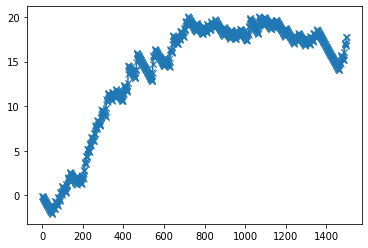

In [ ]:
import matplotlib.pyplot as plt

cum_rewards = np.cumsum(all_rewards)

plt.plot(range(1500), cum_rewards[:1500], "-x")
plt.show()

In [ ]:
np.save("cum_rewards.npy", cum_rewards)